In [1]:
import torch
import torch.nn.functional as F

In [2]:
torch.manual_seed(1)

## 1. 파이토치로 소프트맥스의 비용 함수 구현하기 (low-level)
---
소프트맥스 회귀를 구현함에 있어 우선 소프트맥스 함수의 비용 함수를 low-level로 구현해본다.<br>
3개의 원소를 가진 벡터 텐서를 정의하고, 이 텐서를 통해 소프트맥스 함수를 이해해본다.

In [3]:
z = torch.FloatTensor([1, 2, 3])

이 텐서를 소프트맥스 함수의 입력으로 사용하고, 그 결과를 확인해본다.

In [4]:
hypothesis = F.softmax(z, dim=0)
print(hypothesis)

tensor([0.0900, 0.2447, 0.6652])


3개의 원소의 값이 0과 1사이의 값을 가지는 벡터로 변환된 것을 볼 수 있다. 이 원소들의 값의 합이 1인지 확인해본다.

In [5]:
hypothesis.sum()

tensor(1.)

총 원소의 값의 합은 1이다. 이번에는 비용 함수를 직접 구현해본다. 우선 임의의 3x5 행렬의 크기를 가진 텐서를 만든다.

In [6]:
z = torch.rand(3, 5, requires_grad=True)

이제 이 텐서에 대해서 소프트맥스 함수를 적용한다. 단, 각 샘플에 대해서 소프트맥스 함수를 적용해야하므로 두번째 차원에 대해서 소프트맥스 함수를 적용한다는 의미에서 dim=1을 써준다.

In [7]:
hypothesis = F.softmax(z, dim=1)
print(hypothesis)

tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward>)


이제 각 행의 원소들의 합은 1이 되는 텐서로 변환되었다. 소프트맥스 함수의 출력값은 결국 예측값이다. 즉, 위 텐서는 3개의 샘플에 대해서 5개의 클래스 중 어떤 클래스가 정답인지를 예측한 결과다. <br><br>
이제 각 샘플에 대해서 임의의 레이블을 만든다.

In [8]:
y = torch.randint(5, (3,)).long()
print(y)

tensor([0, 2, 1])


이제 각 레이블에 대해서 원-핫 인코딩을 수행한다.

In [9]:
y_one_hot = torch.zeros_like(hypothesis)
y_one_hot.scatter_(1, y.unsqueeze(1), 1)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])

위의 연산에서 어떻게 원-핫 인코딩이 수행되었는지 본다. 우선, torch.zeros_like(hypothesis)를 통해 모든 원소가 0의 값을 가진 3 x 5 텐서를 만든다. 그리고 이 텐서는 y_one_hot에 저장이 된 상태다.<br><br>
두번째 줄을 해석해본다. y.unsqueeze(1)를 하면 (3,) 크기를 가졌던 y 텐서는 (3 x 1) 텐서가 된다. 즉, 다시 말해서 y.unsqueeze(1)의 결과는 아래와 같다.

In [10]:
print(y.unsqueeze(1))

tensor([[0],
        [2],
        [1]])


이제 비용 함수 연산을 위한 재료들을 전부 설정했다. 소프트맥스 회귀의 비용 함수는 다음과 같았다.
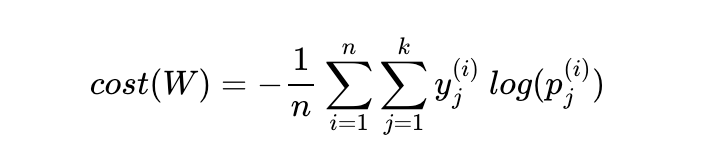
마이너스 부호를 뒤로 빼면 다음 식과도 동일하다.
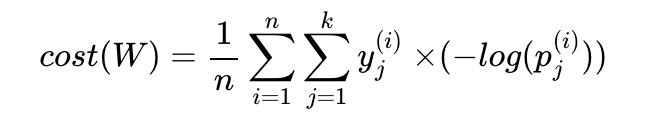
이를 코드로 구현하면 아래와 같다.

In [11]:
cost = (y_one_hot *-torch.log(hypothesis)).sum(dim=1).mean()
print(cost)

tensor(1.4689, grad_fn=<MeanBackward0>)


## 2. 파이토치로 소프트맥스의 비용 함수 구현하기 (high-level)
---
### 1. F.softmax() + torch.log() = F.log_softmax()
앞서 소프트맥스 함수의 결과에 로그을 씌울 때는 다음과 같이 소프트맥스 함수의 출력값을 로그 함수의 입력으로 사용했다.

In [14]:
# Low level
torch.log(F.softmax(z, dim=1))

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]], grad_fn=<LogBackward>)

In [15]:
# High level
F.log_softmax(z, dim=1)

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]],
       grad_fn=<LogSoftmaxBackward>)

### 2. F.log_softmax() + F.nll_loss() = F.cross_entropy()

In [16]:
# Low level
(y_one_hot * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

In [17]:
(y_one_hot * -F.log_softmax(z, dim=1)).sum(dim=1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

이를 더 간단하게 하면 다음과 같다. F.nll_loss()를 사용할 때는 원-핫 벡터를 넣을 필요없이 바로 실제값을 인자로 사용한다.

In [21]:
# High level
F.nll_loss(F.log_softmax(z, dim=1), y)

tensor(1.4689, grad_fn=<NllLossBackward>)

여기서 nll이란 Negative Log Likelihood의 약자다. 위에서 nll_loss는 F.log_softmax()를 수행한 후에 남은 수식들을 수행한다. 이를 더 간단하게 하면 다음과 같이 사용할 수 있다. F.cross_entropy()는 F.log_softmax()와 F.nll_loss()를 포함하고있다.

In [23]:
F.cross_entropy(z, y)

tensor(1.4689, grad_fn=<NllLossBackward>)

- **F.cross_entropy는 비용 함수에 소프트맥스 함수까지 포함하고 있음을 기억해야된다**